In [1]:
import re
import csv
import json
import pandas as pd

from nltk.tokenize import word_tokenize
from py2neo import Graph, Node, Relationship, NodeMatcher
from igraph import Graph as IGraph

### Read the raw book data

In [2]:
with open('./data/Winnetou_Band3.txt', 'r', encoding='utf-8') as f:
    raw_book_data = f.read()

### Prepare the raw book text
* remove double blank lines
* skip the header lines (first 6 lines)
* remove non-word characters
* remove two or more consecutive whitespaces

In [3]:
book_data = raw_book_data.replace('\n\n', ' ')  # remove blank lines
# skip the first 6 lines because they only contain meta info

clean_data = ''
for i, row in enumerate(book_data.splitlines()):
    if i > 5:
        clean_data += str(row)

clean_data = re.sub(r'\W', ' ', clean_data) # remove non-word characters
clean_data = re.sub(r'\s{2,}', ' ', clean_data)  # remove two or more consecutive whitespaces

In [4]:
clean_data[:1000] # print the first 1000 signs

'Ich hatte seit dem frühen Morgen eine tüchtige Strecke zurückgelegt Jetzt fühlte ich mich einigermaßen ermüdet und von den kräftigen Strahlen der hoch im Zenit stehenden Sonne belästigt daher beschloß ich Rast zu halten und mein Mittagsmahl zu mir zu nehmen Die Prairie dehnte sich eine Bodenwelle nach der andern bildend in unendlicher Weite vor mir aus Seit fünf Tagen wo unsere Gesellschaft durch einen zahlreichen Trupp Ogellallahs zersprengt worden war hatte ich weder ein nennenswertes Tier noch die Spur eines Menschen bemerkt und begann nun endlich mich nach irgend einem vernünftigen Wesen zu sehnen an welchem ich erproben konnte ob mir nicht vielleicht infolge des lange anhaltenden Schweigens die Sprache verloren gegangen sei Einen Bach oder ein sonstiges Wasser gab es hier nicht Wald oder Buschwerk ebensowenig ich brauchte also nicht lange zu wählen und konnte Halt machen wo es mir eben beliebte Ich sprang in einem Wellentale zur Erde hobbelte Trapperausdruck für mit dem Lasso die

## List of names consisting multiple words

In [5]:
mult_word_names = ['Fred Buller', 'Gustel Ebersbach', 'Ebersbachs Gustel', 'Don Fernando', 'Donna Elvira de Gonzalez',
                  'Donna Elvira', 'Elvira de Gonzalez', 'Sennor Henrico Gonzalez', 'Sennor Henrico', 'Henrico Gonzalez',
                   'Samuel Haller', 'Sam Hawkens', 'Vater Hillmann', 'alte Hillmann', 'jungen Hillmann',
                   'junge Hillmann', 'Frau Willys', 'Juwelier Marshall', 'Bernard Marshall', 'Bernard Marshall',
                   'Bill Meinert', 'Fred Morgan', 'Patrik Morgan', 'Old Shatterhand', 'Old Firehand', 'Pidas Squaw',
                   'Fred Walker']

### Replace the whitespaces inside names words with hyphen

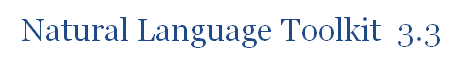

In [6]:
for name in mult_word_names:
    tokens = word_tokenize(name)
    replace_name = ""
    for i, token in enumerate(tokens):
        if i > 0:
            replace_name += '-' + token
        else:
            replace_name += token

    clean_data = re.sub(name, replace_name, clean_data)
clean_data[:1000]

'Ich hatte seit dem frühen Morgen eine tüchtige Strecke zurückgelegt Jetzt fühlte ich mich einigermaßen ermüdet und von den kräftigen Strahlen der hoch im Zenit stehenden Sonne belästigt daher beschloß ich Rast zu halten und mein Mittagsmahl zu mir zu nehmen Die Prairie dehnte sich eine Bodenwelle nach der andern bildend in unendlicher Weite vor mir aus Seit fünf Tagen wo unsere Gesellschaft durch einen zahlreichen Trupp Ogellallahs zersprengt worden war hatte ich weder ein nennenswertes Tier noch die Spur eines Menschen bemerkt und begann nun endlich mich nach irgend einem vernünftigen Wesen zu sehnen an welchem ich erproben konnte ob mir nicht vielleicht infolge des lange anhaltenden Schweigens die Sprache verloren gegangen sei Einen Bach oder ein sonstiges Wasser gab es hier nicht Wald oder Buschwerk ebensowenig ich brauchte also nicht lange zu wählen und konnte Halt machen wo es mir eben beliebte Ich sprang in einem Wellentale zur Erde hobbelte Trapperausdruck für mit dem Lasso die

In [7]:
# manually created list with persons
persons_dict = {'Alma': ['Alma'],
                'Bob': ['Bob'],
                'Buller': ['Fred-Buller', 'Buller'],
                'Capitano': ['Capitano'],
                'Clay': ['Clay'],
                'Conchez': ['Conchez'],
                'Auguste': ['Gustel-Ebersbach', 'Ebersbachs-Gustel', 'Ebersbach'],
                'Eulalia': ['Eulalia'],
                'Fernando': ['Don-Fernando'],
                'Gates': ['Gates'],
                'ElviraG.': ['Donna-Elvira-de-Gonzalez', 'Donna-Elvira', 'Elvira-de-Gonzalez'],
                'HenricG.': ['Sennor-Henrico-Gonzalez', 'Sennor-Henrico', 'Henrico-Gonzalez'],
                'Haller': ['Samuel-Haller', 'Haller'],
                'SamHawkens': ['Sam-Hawkens', 'Sam', 'Sams'],
                'Hi-Iah-dih': ['Hi-Iah-dih'],
                'V.Hillmann': ['Vater-Hillmann', 'alte-Hillmann', 'Hillmann'],
                'W.Hillmann': ['Willy', 'jungen-Hillmann', 'junge-Hillmann'],
                'Fr.HillmannJung': ['Frau-Willys'],
                'Hoblyn': ['Hoblyn'],
                'Holfert': ['Holfert'],
                'Inta': ['Inta'],
                'Kakho-oto': ['Kakho-oto'],
                'Ka-wo-mien': ['Ka-wo-mien'],
                'Ko-itse': ['Ko-itse'],
                'Ko-tu-cho': ['Ko-tu-cho'],
                'Ma-ram': ['Ma-ram'],
                'A.Marshall': ['Juwelier-Marshall'],
                'B.Marshall': ['Bernard-Marshall', 'Bernard-Marshall', 'Bernards', 'Marshall'],
                'Ma-ti-ru': ['Ma-ti-ru'],
                'B.Meinert': ['Bill-Meinert'],
                'F.Morgan': ['Fred-Morgan', 'Morgan'],
                'P.Morgan': ['Patrik-Morgan'],
                'Ohiamann': ['Ohiomann'],
                'Ohlers': ['Ohlers'],
                'OldShatterhand': ['Old-Shatterhand', 'Shatterhand'],
                'OldFirehand': ['Old-Firehand'],
                'Pida': ['Pida'],
                'PidasSquaw': ['Pidas-Squaw'],
                'Rudge': ['Rudge'],
                'Sanchez': ['Sanchez'],
                'Sans-ear': ['Sans-ear'],
                'Santer': ['Santer'],
                'Shelley': ['Shelley'],
                'Summer': ['Summer'],
                'Sus-Homascha': ['Sus-Homascha'],
                'Tangua': ['Tangua'],
                'Til-Lata': ['Til-Lata'],
                'To-kei-chun': ['To-kei-chun'],
                'F.Walker': ['Fred-Walker', 'Walker'],
                'Williams': ['Williams'],
                'Winnetou': ['Winnetou'],
                'Yato-Ka': ['Yato-Ka']
                }

In [8]:
relationship_dict = {}
#relationships_df = pd.DataFrame(columns=['Source', 'Target', 'Weight'])

tokenized_text = word_tokenize(clean_data)
substring_length = 15

### search names within 15 words

* iterate substring if first person found

In [10]:
def _search_persons(tokenized_string, primary_person=None):
    for key, value in persons_dict.items():
        for i, token in enumerate(tokenized_string):
            if token in value and key != primary_person:
                    dict_key = primary_person + '_' + key
                    if dict_key in relationship_dict.keys():
                        relationship_dict[dict_key] += 1
                    else:
                        relationship_dict[dict_key] = 1

* search for name inside tokenized text
* if one name found, search inside substring

In [11]:
for key, value in persons_dict.items():
    for i, token in enumerate(tokenized_text):
        if token in value:
            found_person = key
            tmp_substring = tokenized_text[i - substring_length:i] + tokenized_text[i+1:i + substring_length]
            _search_persons(tmp_substring, found_person)


### Print relationships dictionary and prepare for drawing

In [12]:
relationship_dict

{'Alma_Eulalia': 4,
 'Alma_Fernando': 2,
 'Alma_HenricG.': 1,
 'Bob_SamHawkens': 11,
 'Bob_Williams': 2,
 'Bob_Hoblyn': 3,
 'Bob_Holfert': 3,
 'Bob_Winnetou': 7,
 'Bob_Eulalia': 1,
 'Bob_F.Morgan': 1,
 'Buller_B.Marshall': 1,
 'Capitano_Williams': 2,
 'Capitano_Hoblyn': 5,
 'Capitano_SamHawkens': 1,
 'Capitano_Conchez': 7,
 'Capitano_Winnetou': 3,
 'Clay_Gates': 10,
 'Clay_Summer': 15,
 'Clay_Santer': 2,
 'Clay_Pida': 1,
 'Clay_OldShatterhand': 1,
 'Conchez_Capitano': 7,
 'Conchez_Hoblyn': 4,
 'Conchez_Winnetou': 1,
 'Eulalia_Alma': 5,
 'Eulalia_Fernando': 11,
 'Eulalia_Bob': 1,
 'Fernando_Eulalia': 11,
 'Fernando_Alma': 2,
 'Gates_Clay': 10,
 'Gates_Summer': 10,
 'Gates_Santer': 12,
 'Gates_Pida': 2,
 'Gates_OldShatterhand': 1,
 'HenricG._Alma': 1,
 'HenricG._B.Marshall': 1,
 'Haller_OldShatterhand': 1,
 'Haller_OldFirehand': 1,
 'Haller_Winnetou': 4,
 'Haller_SamHawkens': 2,
 'Haller_F.Walker': 1,
 'SamHawkens_F.Morgan': 5,
 'SamHawkens_Bob': 11,
 'SamHawkens_B.Marshall': 6,
 'SamHaw

## NetworkX
Instantiate networkx graph and add egdes and nodes

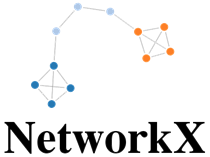

In [14]:
import networkx as nx
import matplotlib.pyplot as plt
ng = nx.Graph()
tmp_list = []

for key, value in relationship_dict.items():
    if value > 2:  # only weights over 2 will be recognized as interaction
        tmp_list = key.split('_')
        tmp_list.append(value)

        print("Source: {}, Target: {}, Weight {}".format(tmp_list[0], tmp_list[1], tmp_list[2]))
        ng.add_edge(tmp_list[0], tmp_list[1], weight=int(tmp_list[2]))

Source: Alma, Target: Eulalia, Weight 4
Source: Bob, Target: SamHawkens, Weight 11
Source: Bob, Target: Hoblyn, Weight 3
Source: Bob, Target: Holfert, Weight 3
Source: Bob, Target: Winnetou, Weight 7
Source: Capitano, Target: Hoblyn, Weight 5
Source: Capitano, Target: Conchez, Weight 7
Source: Capitano, Target: Winnetou, Weight 3
Source: Clay, Target: Gates, Weight 10
Source: Clay, Target: Summer, Weight 15
Source: Conchez, Target: Capitano, Weight 7
Source: Conchez, Target: Hoblyn, Weight 4
Source: Eulalia, Target: Alma, Weight 5
Source: Eulalia, Target: Fernando, Weight 11
Source: Fernando, Target: Eulalia, Weight 11
Source: Gates, Target: Clay, Weight 10
Source: Gates, Target: Summer, Weight 10
Source: Gates, Target: Santer, Weight 12
Source: Haller, Target: Winnetou, Weight 4
Source: SamHawkens, Target: F.Morgan, Weight 5
Source: SamHawkens, Target: Bob, Weight 11
Source: SamHawkens, Target: B.Marshall, Weight 6
Source: SamHawkens, Target: P.Morgan, Weight 3
Source: SamHawkens, Tar

## Draw Network Graph with NetworkX 

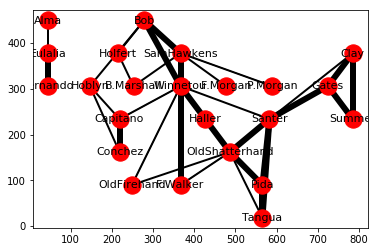

In [17]:
from networkx import nx_pydot
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

e_small = [(u, v) for (u, v, d) in ng.edges(data=True) if d['weight'] <= 3]
e_middle = [(u, v) for (u, v, d) in ng.edges(data=True) if d['weight'] <= 6]
e_large = [(u, v) for (u, v, d) in ng.edges(data=True) if d['weight'] > 6]
#pos = nx.spring_layout(ng)  # positions for all nodes
pos = nx.nx_pydot.graphviz_layout(ng, prog='dot')

# nodes
nx.draw_networkx_nodes(ng, pos, node_size=300)

# edges
nx.draw_networkx_edges(ng, pos, edgelist=e_small, width=1)
nx.draw_networkx_edges(ng, pos, edgelist=e_middle, width=2)
nx.draw_networkx_edges(ng, pos, edgelist=e_large, width=6)

# labels
nx.draw_networkx_labels(ng, pos, font_size=11, font_family='sans-serif')

#plt.axis('off')  # disable axis
plt.show()


### Save to Neo4j database

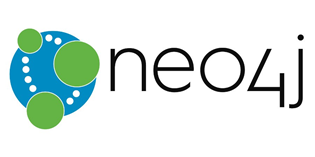

Define methods for adding and getting nodes relionships

In [18]:
with open('neo4j_creds.json') as f:
    data = json.load(f)
username = data['username']
password = data['password']
graph = Graph(host="localhost", username=username, password=password)

def add_node_by_name(name):
    node = Node("Character", name=name)
    graph.create(node)

    return node

def get_node_by_name(name):
    matcher = NodeMatcher(graph)
    node = matcher.match('Character', name=name).first()

    return node

def add_relationship(from_person, to_person, weight):
    graph.create(Relationship(from_person, "INTERACTS", to_person, weight=int(weight)))
    

Iteare relationship_dict and add nodes

In [19]:
tmp_list = []
for key, value in relationship_dict.items():
    if value > 2:  # only weights over 2 will be recognized as interaction
        tmp_list = key.split('_')
        source = tmp_list[0]
        target = tmp_list[1]
        weight = value
        
        first_node = get_node_by_name(source)
        second_node = get_node_by_name(target)

        if not first_node:
            first_node = add_node_by_name(source)
        if not second_node:
            second_node = add_node_by_name(target)

        add_relationship(first_node, second_node, weight=int(weight))

### Add PageRank centrality and walktrap communitie property to nodes

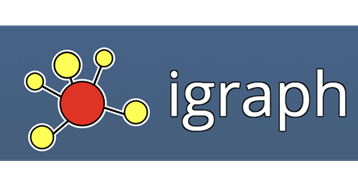

In [20]:
def add_pagerank():
    query = '''
    MATCH (c1:Character)-[r:INTERACTS]->(c2:Character)
    RETURN c1.name, c2.name, r.weight AS weight
    '''
    ig = IGraph.TupleList(graph.run(query), weights=True)

    pg = ig.pagerank()
    pgvs = []
    for p in zip(ig.vs, pg):
        print(p)
        pgvs.append({"name": p[0]["name"], "pg": p[1]})

    write_clusters_query = '''
    UNWIND {nodes} AS n
    MATCH (c:Character) WHERE c.name = n.name
    SET c.pagerank = n.pg
    '''

    graph.run(write_clusters_query, nodes=pgvs)

def add_communites():
    query = '''
    MATCH (c1:Character)-[r:INTERACTS]->(c2:Character)
    RETURN c1.name, c2.name, r.weight AS weight
    '''
    ig = IGraph.TupleList(graph.run(query), weights=True)

    clusters = IGraph.community_walktrap(ig, weights="weight").as_clustering()

    nodes = [{"name": node["name"]} for node in ig.vs]
    for node in nodes:
        idx = ig.vs.find(name=node["name"]).index
        node["community"] = clusters.membership[idx]

    write_clusters_query = '''
    UNWIND {nodes} AS n
    MATCH (c:Character) WHERE c.name = n.name
    SET c.community = toInt(n.community)
    '''

    graph.run(write_clusters_query, nodes=nodes)
    
add_pagerank()
add_communites()

(igraph.Vertex(<igraph.Graph object at 0x00000280A27ADD68>, 0, {'name': 'Eulalia'}), 0.05586153908285967)
(igraph.Vertex(<igraph.Graph object at 0x00000280A27ADD68>, 1, {'name': 'Alma'}), 0.03661195466917155)
(igraph.Vertex(<igraph.Graph object at 0x00000280A27ADD68>, 2, {'name': 'Fernando'}), 0.03661195466917155)
(igraph.Vertex(<igraph.Graph object at 0x00000280A27ADD68>, 3, {'name': 'Winnetou'}), 0.076648073451877)
(igraph.Vertex(<igraph.Graph object at 0x00000280A27ADD68>, 4, {'name': 'Bob'}), 0.048933590017789866)
(igraph.Vertex(<igraph.Graph object at 0x00000280A27ADD68>, 5, {'name': 'Holfert'}), 0.0381524477759494)
(igraph.Vertex(<igraph.Graph object at 0x00000280A27ADD68>, 6, {'name': 'Hoblyn'}), 0.043888501522451745)
(igraph.Vertex(<igraph.Graph object at 0x00000280A27ADD68>, 7, {'name': 'SamHawkens'}), 0.06818059568853102)
(igraph.Vertex(<igraph.Graph object at 0x00000280A27ADD68>, 8, {'name': 'P.Morgan'}), 0.030536728247589)
(igraph.Vertex(<igraph.Graph object at 0x00000280A2

### Visualize using neovis.js

In [ ]:
from IPython.display import HTML
HTML(filename='neovis.js/examples/visualize_graph.html')